In [1]:
#importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud

#for feature engineering
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


#import to split train and test data
from sklearn.model_selection import train_test_split

#import for Ml classfifiers
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

#import for prediction evaluation
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, precision_score
from sklearn.model_selection import GridSearchCV

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_curve, auc

#### Load and Clean Dataset

In [2]:
#loading the dataset into a dataframe
email_phish = pd.read_csv("C:\\Users\E7470\OneDrive - Robert Gordon University\Documents\Term 3\Dataset\email dataset\spamham2.csv", dtype={'Email Content': str})
email_phish.head()

,Email Content,Label
0,thank you .,ham
1,"sally : what timing , ask and you shall receiv...",ham
2,"over the next few weeks , project apollo and b...",ham
3,a ) year end reviews - report needs generating...,ham
4,"good morning , i ' d love to go get some coffe...",ham


In [3]:
#check for number of rows and columns in the dataset befor any processing
email_phish.shape

(32784, 2)

In [4]:
#check for balance of spam and ham email befor any processing
email_phish['Label'].value_counts()

ham     16623
spam    16081
Name: Label, dtype: int64

In [5]:
#chekcing for and identifying any null values
email_phish.isnull().sum()

Email Content    450
Label             80
dtype: int64

In [6]:
email_phish.dropna(inplace=True)

In [7]:
#check for number of rows and columns in the dataset 
email_phish.shape

(32254, 2)

In [8]:
#check for balance of spam and ham email
email_phish['Label'].value_counts()

ham     16492
spam    15762
Name: Label, dtype: int64

#### Feature Engineering

In [9]:
#using the numpy char module to convert all text to lowercase
email_content = email_phish['Email Content']
def lower_case(email_content):
    return np.char.lower(email_content)

In [10]:
#using the nltk stop words to remove stop words and tokenize
def del_stop_words(email_content):
    stop_words = stopwords.words('english')
    words = word_tokenize(str(email_content))
    new_text = ""
    for w in words:
        if w not in stop_words and len(w) > 1:
            new_text = new_text + " " + w
    return new_text


In [11]:
#using the char function to remove punction and spec characters
def remove_punctuation(email_content):
    symbols = "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n"
    for i in range(len(symbols)):
        email_content = np.char.replace(email_content, symbols[i], ' ')
        email_content = np.char.replace(email_content, "  ", " ")
    data = np.char.replace(email_content, ',', '')
    return email_content

In [12]:
#stemmatization using PortStemmer
def stemm(email_content):
    stemmer= PorterStemmer()
    
    tokens = word_tokenize(str(email_content))
    new_text = ""
    for w in tokens:
        new_text = new_text + " " + stemmer.stem(w)
    return new_text

In [13]:
#lemmatization using WordNetlemmatizer
def lemma(email_content):
    lemma= WordNetLemmatizer()
    
    tokens = word_tokenize(str(email_content))
    new_text = ""
    for w in tokens:
        new_text = new_text + " " + lemma.lemmatize(w)
    return new_text

In [14]:
def preprocess(email_content):
    email_content = lower_case(email_content)
    email_content = del_stop_words(email_content)
    email_content = remove_punctuation(email_content)
    email_content = stemm(email_content)
    email_content = lemma(email_content)
    return email_content

In [15]:
def apply_preprocess(series):
    preprocessed_data = series.apply(preprocess)
    return preprocessed_data

In [16]:
data = apply_preprocess(email_phish['Email Content'])
print(data)

0                                                    thank
1         salli time ask shall receiv per discus list u...
2         next week project apollo beyond conduct final...
3         year end review report need gener like mid ye...
4         good morn love go get coffe rememb annoy proj...
                               ...                        
32779     gener viagra find everyon switch ideal solut ...
32780          learn last 10 time longer bed read plod net
32781     free date site fill ton sex addict flower gif...
32782     hi need softwar give link http zk net softyou...
32783     html bodi pwhi take look plose weight week pa...
Name: Email Content, Length: 32254, dtype: object


#### Split Dataset - Train & Test

In [17]:
#setting email content and identifying label in variable
X = data
Y = email_phish['Label']

In [18]:
#splitting test size into 80/20, shuffle the data due to data balancing
X_trainset, X_testset, Y_trainset, Y_testset = train_test_split(X,Y, test_size=0.2, random_state= 3, shuffle = True)

#### Feature Extraction - Bag of Words Using Word Vectorizer

In [19]:
feature_extraction = CountVectorizer(min_df = 2)

X_trainset_features= feature_extraction.fit_transform(X_trainset)
X_testset_features = feature_extraction.transform(X_testset)

feature_names = feature_extraction.get_feature_names_out(X_trainset_features)
df = pd.DataFrame(feature_names).to_numpy()
print(df)

from sklearn.preprocessing import LabelEncoder
#encoding the labels, this is done differently to avoid leakage and overfitting
encode = LabelEncoder()
Y_trainset = encode.fit_transform(Y_trainset)
Y_testset = encode.fit_transform(Y_testset)

Y_testset_decode = encode.inverse_transform(Y_testset)
print('Encoded labels: ', Y_testset[0:5])
print('Decoded labels: ', Y_testset_decode[0:5])

[['00']
 ['000']
 ['0000']
 ...
 ['zzucpkow']
 ['zzxtfeerekvwkug']
 ['zzzz']]
Encoded labels:  [1 1 0 0 0]
Decoded labels:  ['spam' 'spam' 'ham' 'ham' 'ham']


#### Models Training and Evaluation 

#### Random Forest Classifier 

In [20]:
#training and fitting the model

rng = np.random.RandomState(0)

rf = RandomForestClassifier(n_estimators=100,n_jobs=-1, random_state = rng)

rf.fit(X_trainset_features, Y_trainset)

RandomForestClassifier(n_jobs=-1,
                       random_state=RandomState(MT19937) at 0x2D65B8E7D40)

In [21]:
#evaluating trained model
rf_train =rf.predict(X_trainset_features)
rf_train_acc = accuracy_score(Y_trainset, rf_train)

print("Accuracy on training data: " , rf_train_acc)

#evaluating accuracy on test data
rf_test = rf.predict(X_testset_features)
rf_test_acc = accuracy_score(Y_testset,rf_test)

print("Accuracy on test data: " , rf_test_acc)

Accuracy on training data:  0.9997674688989653
Accuracy on test data:  0.9843435126337002


              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3349
           1       0.98      0.98      0.98      3102

    accuracy                           0.98      6451
   macro avg       0.98      0.98      0.98      6451
weighted avg       0.98      0.98      0.98      6451



Text(0.5, 1.0, 'Random Forest Classifier Confusion Matrix - BoW')

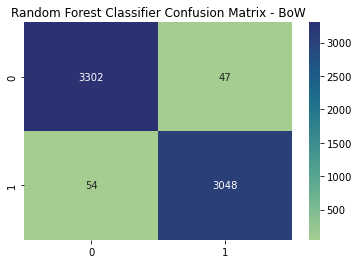

In [22]:
#Evaluating the classficiation
rf_class_report = (classification_report(Y_testset, rf_test))
print(rf_class_report)

rf_CM = confusion_matrix(Y_testset, rf_test)
sns.heatmap(rf_CM, annot = True, fmt='d', cmap='crest')
plt.title("Random Forest Classifier Confusion Matrix - BoW")

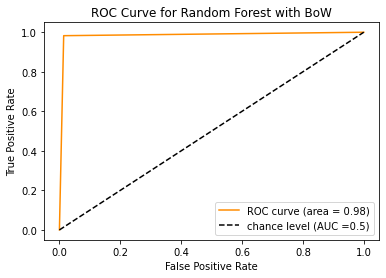

In [23]:
#calculate ROC curve
fpr, tpr, thresholds = roc_curve(Y_testset, rf_test)

#calculating auc
rf_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % rf_auc)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC =0.5)")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest with BoW')
plt.legend()
plt.show()

#### K Neighbor Classifier

In [24]:
#training  and fitting the model
knc= KNeighborsClassifier()


knc.fit(X_trainset_features, Y_trainset)

KNeighborsClassifier()

In [25]:
#evaluating trained model
knc_train =knc.predict(X_trainset_features)
knc_train_acc = accuracy_score(Y_trainset, knc_train)

print("Accuracy on training data: " , knc_train_acc)

#evaluating accuracy on test data
knc_test = knc.predict(X_testset_features)
knc_test_acc = accuracy_score(Y_testset,knc_test)

print("Accuracy on test data: " , knc_test_acc)

Accuracy on training data:  0.9372166027206139
Accuracy on test data:  0.9167570919237328


              precision    recall  f1-score   support

           0       0.95      0.89      0.92      3349
           1       0.89      0.95      0.92      3102

    accuracy                           0.92      6451
   macro avg       0.92      0.92      0.92      6451
weighted avg       0.92      0.92      0.92      6451



Text(0.5, 1.0, 'K-Neighbors Confusion Matrix - BoW')

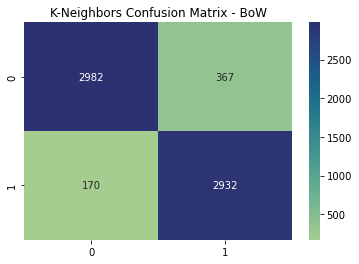

In [26]:
#Evaluating the classficiation 
#Evaluating the classficiation 
knc_class_report = (classification_report(Y_testset, knc_test))
print(knc_class_report)

knc_CM = confusion_matrix(Y_testset, knc_test)
sns.heatmap(knc_CM, annot = True, fmt='d', cmap='crest')
plt.title("K-Neighbors Confusion Matrix - BoW")

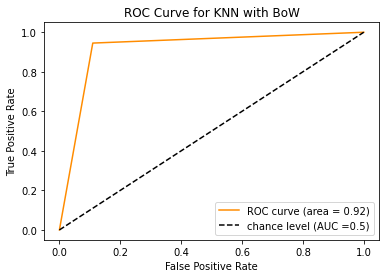

In [27]:
fpr, tpr, thresholds = roc_curve(Y_testset, knc_test)

#calculating auc
knc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % knc_auc)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC =0.5)")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for KNN with BoW')
plt.legend()
plt.show()

#### Decision Tree Classifier

In [28]:
dtc= DecisionTreeClassifier()

#training the model
dtc.fit(X_trainset_features, Y_trainset)

DecisionTreeClassifier()

In [29]:
#evaluating trained model
dtc_train =dtc.predict(X_trainset_features)
dtc_train_acc = accuracy_score(Y_trainset, dtc_train)

print("Accuracy on training data: " , dtc_train_acc)

#evaluating accuracy on test data
dtc_test = dtc.predict(X_testset_features)
dtc_test_acc = accuracy_score(Y_testset,dtc_test)

print("Accuracy on test data: " , dtc_test_acc)

Accuracy on training data:  0.9997674688989653
Accuracy on test data:  0.9510153464579135


              precision    recall  f1-score   support

           0       0.95      0.96      0.95      3349
           1       0.95      0.95      0.95      3102

    accuracy                           0.95      6451
   macro avg       0.95      0.95      0.95      6451
weighted avg       0.95      0.95      0.95      6451



Text(0.5, 1.0, 'Decision Tree Classifier Confusion Matrix - BoW')

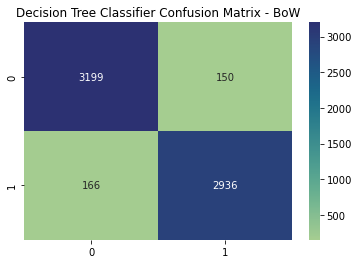

In [30]:
#Evaluating the classficiation 
#Evaluating the classficiation 
dtc_class_report = (classification_report(Y_testset, dtc_test))
print(dtc_class_report)

dtc_CM = confusion_matrix(Y_testset, dtc_test)
sns.heatmap(dtc_CM, annot = True, fmt='d', cmap='crest')
plt.title("Decision Tree Classifier Confusion Matrix - BoW")

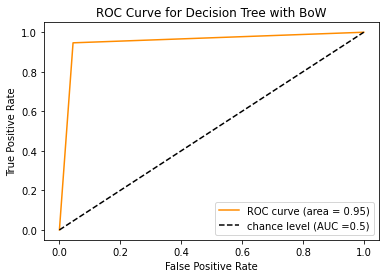

In [31]:
fpr, tpr, thresholds = roc_curve(Y_testset, dtc_test)

#calculating auc
dtc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % dtc_auc)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC =0.5)")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decision Tree with BoW')
plt.legend()
plt.show()

#### Support Vector Machine

In [32]:
#the parmeter is set to linear since simple SVM can only classfy linealry seperable data
svm = SVC(kernel = 'linear', C = 1, gamma = 'scale')

#training the model
svm.fit(X_trainset_features, Y_trainset)

SVC(C=1, kernel='linear')

In [33]:
#evaluating trained model
svm_train =svm.predict(X_trainset_features)
svm_train_acc = accuracy_score(Y_trainset, svm_train)

print("Accuracy on training data: " , svm_train_acc)

#evaluating accuracy on test data
svm_test = svm.predict(X_testset_features)
svm_test_acc = accuracy_score(Y_testset,svm_test)

print("Accuracy on test data: " , svm_test_acc)

Accuracy on training data:  0.9995349377979305
Accuracy on test data:  0.9784529530305379


              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3349
           1       0.98      0.98      0.98      3102

    accuracy                           0.98      6451
   macro avg       0.98      0.98      0.98      6451
weighted avg       0.98      0.98      0.98      6451



Text(0.5, 1.0, 'Support Vector Machine Confusion Matrix - BoW')

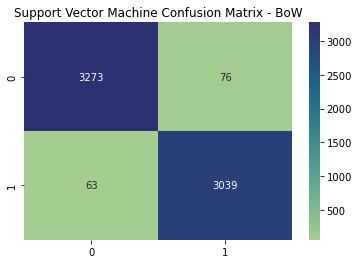

In [34]:
#Evaluating the classficiation 
svm_class_report = (classification_report(Y_testset, svm_test))
print(svm_class_report)

svm_CM = confusion_matrix(Y_testset, svm_test)
sns.heatmap(svm_CM, annot = True, fmt='d', cmap='crest')
plt.title("Support Vector Machine Confusion Matrix - BoW")

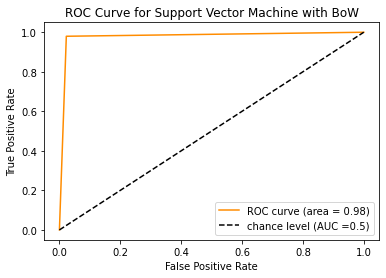

In [35]:
fpr, tpr, thresholds = roc_curve(Y_testset, svm_test)

#calculating auc
svm_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % svm_auc)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC =0.5)")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Support Vector Machine with BoW')
plt.legend()
plt.show()

#### Logistic Regression

In [36]:
lr = LogisticRegression(max_iter = 100000)

#training the model
lr.fit(X_trainset_features, Y_trainset)

LogisticRegression(max_iter=100000)

In [37]:
#evaluating trained model
lr_train = lr.predict(X_trainset_features)
lr_train_acc = accuracy_score(Y_trainset, lr_train)

print("Accuracy on training data: " , lr_train_acc)

#evaluating accuracy on test data
lr_test = lr.predict(X_testset_features)
lr_test_acc = accuracy_score(Y_testset, lr_test)

print("Accuracy on test data: " , lr_test_acc)

Accuracy on training data:  0.9980622408247103
Accuracy on test data:  0.9857386451712913


              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3349
           1       0.98      0.99      0.99      3102

    accuracy                           0.99      6451
   macro avg       0.99      0.99      0.99      6451
weighted avg       0.99      0.99      0.99      6451



Text(0.5, 1.0, 'Logistic Regression Confusion Matrix - BoW')

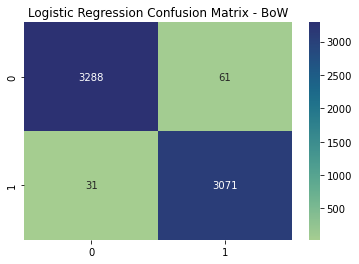

In [38]:
#Evaluating the classficiation 
lr_class_report = (classification_report(Y_testset, lr_test))
print(lr_class_report)

lr_CM = confusion_matrix(Y_testset, lr_test)
sns.heatmap(lr_CM, annot = True, fmt='d', cmap='crest')
plt.title("Logistic Regression Confusion Matrix - BoW")

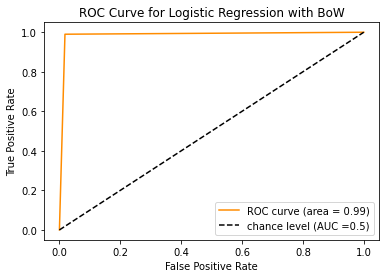

In [39]:
fpr, tpr, thresholds = roc_curve(Y_testset, lr_test)

#calculating auc
lr_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % lr_auc)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC =0.5)")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression with BoW')
plt.legend()
plt.show()

#### XGBoost

In [40]:
xgb = XGBClassifier()

#training the model
xgb.fit(X_trainset_features, Y_trainset)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [41]:
#evaluating trained model
xgb_train = xgb.predict(X_trainset_features)
xgb_train_acc = accuracy_score(Y_trainset, xgb_train)

print("Accuracy on training data: " , xgb_train_acc)

#evaluating accuracy on test data
xgb_test = xgb.predict(X_testset_features)
xgb_test_acc = accuracy_score(Y_testset,xgb_test)

print("Accuracy on test data: " , xgb_test_acc)

Accuracy on training data:  0.9850017439832578
Accuracy on test data:  0.9787629824833359


              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3349
           1       0.96      0.99      0.98      3102

    accuracy                           0.98      6451
   macro avg       0.98      0.98      0.98      6451
weighted avg       0.98      0.98      0.98      6451



Text(0.5, 1.0, 'XGBoost Confusion Matrix - BoW')

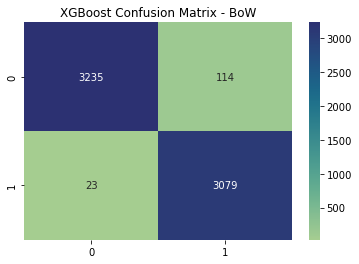

In [42]:
#Evaluating the classficiation 
xgb_class_report = (classification_report(Y_testset, xgb_test))
print(xgb_class_report)

xgb_CM = confusion_matrix(Y_testset, xgb_test)
sns.heatmap(xgb_CM, annot = True, fmt='d', cmap='crest')
plt.title("XGBoost Confusion Matrix - BoW")

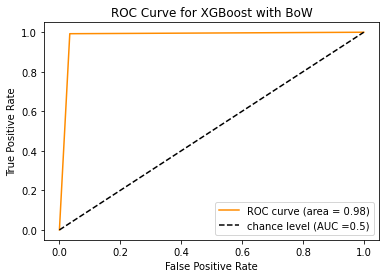

In [43]:
fpr, tpr, thresholds = roc_curve(Y_testset, xgb_test)

#calculating auc
xgb_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % xgb_auc)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC =0.5)")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost with BoW')
plt.legend()
plt.show()

#### AdaBoostClassifier

In [44]:
adb = AdaBoostClassifier(DecisionTreeClassifier())

#training the model
adb.fit(X_trainset_features, Y_trainset)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier())

In [45]:
#evaluating trained model
adb_train = adb.predict(X_trainset_features)
adb_train_acc = accuracy_score(Y_trainset, adb_train)

print("Accuracy on training data: " , adb_train_acc)

#evaluating accuracy on test data
adb_test = adb.predict(X_testset_features)
adb_test_acc = accuracy_score(Y_testset,adb_test)

print("Accuracy on test data: " , adb_test_acc)

Accuracy on training data:  0.9997674688989653
Accuracy on test data:  0.9552007440706867


              precision    recall  f1-score   support

           0       0.97      0.94      0.96      3349
           1       0.94      0.97      0.95      3102

    accuracy                           0.96      6451
   macro avg       0.96      0.96      0.96      6451
weighted avg       0.96      0.96      0.96      6451



Text(0.5, 1.0, 'AdaBoost Confusion Matrix - BoW')

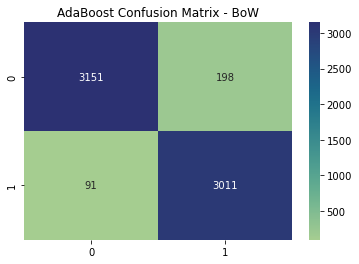

In [46]:
#Evaluating the classficiation 
adb_class_report = (classification_report(Y_testset, adb_test))
print(adb_class_report)

adb_CM = confusion_matrix(Y_testset, adb_test)
sns.heatmap(adb_CM, annot = True, fmt='d', cmap='crest')
plt.title("AdaBoost Confusion Matrix - BoW")

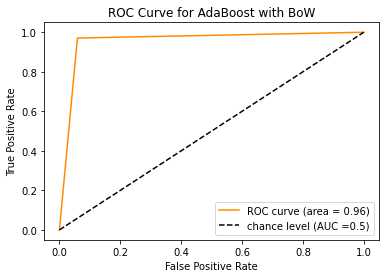

In [47]:
fpr, tpr, thresholds = roc_curve(Y_testset, adb_test)

#calculating auc
adb_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % adb_auc)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC =0.5)")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for AdaBoost with BoW')
plt.legend()
plt.show()

In [48]:
for_models_predicted = ['Random Forest(RF)','K Nearest Neighbors (KNN)','Decision Tree (DT)',
                   'Support Vector (SV)', 'Logistics Regression (LR)','XGBOOST (XGB)','AdaBoost (ADB)',]
classification_reports = [rf_class_report, knc_class_report, dtc_class_report, svm_class_report,
                       lr_class_report, xgb_class_report, adb_class_report]

for i, model_name in enumerate(for_models_predicted):
    print(f"Classification report for {model_name}: with BoW")
    print(classification_reports[i])

Classification report for Random Forest(RF): with BoW
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3349
           1       0.98      0.98      0.98      3102

    accuracy                           0.98      6451
   macro avg       0.98      0.98      0.98      6451
weighted avg       0.98      0.98      0.98      6451

Classification report for K Nearest Neighbors (KNN): with BoW
              precision    recall  f1-score   support

           0       0.95      0.89      0.92      3349
           1       0.89      0.95      0.92      3102

    accuracy                           0.92      6451
   macro avg       0.92      0.92      0.92      6451
weighted avg       0.92      0.92      0.92      6451

Classification report for Decision Tree (DT): with BoW
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      3349
           1       0.95      0.95      0.95      3102

    accurac

In [49]:
for_models_predicted = ['Random Forest(RF)','K Nearest Neighbors (KNN)','Decision Tree (DT)',
                   'Support Vector (SV)', 'Logistics Regression (LR)','XGBOOST (XGB)','AdaBoost (ADB)']
acc_list = [rf_test_acc, knc_test_acc, dtc_test_acc, svm_test_acc,
                       lr_test_acc, xgb_test_acc, adb_test_acc]

result = pd.DataFrame({'Models with BoW':for_models_predicted,'Accuracy %': acc_list})
result.set_index('Models with BoW',inplace=True)
result


,Accuracy %
Models with BoW,
Random Forest(RF),0.984344
K Nearest Neighbors (KNN),0.916757
Decision Tree (DT),0.951015
Support Vector (SV),0.978453
Logistics Regression (LR),0.985739
XGBOOST (XGB),0.978763
AdaBoost (ADB),0.955201


#### Implementing GridSearch for SVM 

[LibSVM]Accuracy on test data:  0.9781429235777399
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3349
           1       0.97      0.99      0.98      3102

    accuracy                           0.98      6451
   macro avg       0.98      0.98      0.98      6451
weighted avg       0.98      0.98      0.98      6451



Text(0.5, 1.0, 'Support Vector Machine Confusion Matrix with GridSearch - BoW')

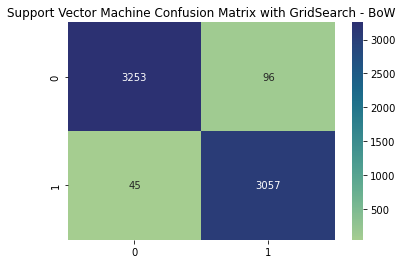

In [55]:
svc_gr = SVC(class_weight='balanced',probability=True, verbose=True)
parameters = {'C':[0.1, 1, 10]}
clf_svc = GridSearchCV(svc_gr, parameters, cv = 5, n_jobs = -1).fit(X_trainset_features, Y_trainset)

clf_svc.best_params_

clf_svc.best_estimator_

clf_svc_pred = clf_svc.predict(X_testset_features)
svc_detect = accuracy_score(Y_testset, clf_svc_pred)

print("Accuracy on test data: " , svc_detect)

#Evaluating the classficiation 
print(classification_report(Y_testset, clf_svc_pred))

clf_svc_CM = confusion_matrix(Y_testset, clf_svc_pred)
sns.heatmap(clf_svc_CM, annot = True, fmt='d', cmap='crest')
plt.title("Support Vector Machine Confusion Matrix with GridSearch - BoW")

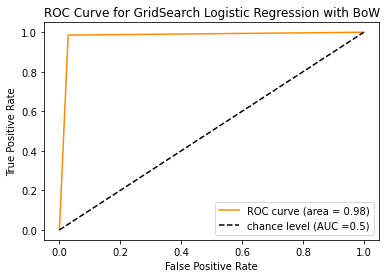

In [57]:
fpr, tpr, thresholds = roc_curve(Y_testset, clf_svc_pred)

#calculating auc
clf_svc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % clf_svc_auc)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC =0.5)")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for GridSearch Logistic Regression with BoW')
plt.legend()
plt.show()

#### Implementing GridSearch with Logistic Regression

C:\Users\E7470\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy on test data:  0.9857386451712913
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3349
           1       0.98      0.99      0.99      3102

    accuracy                           0.99      6451
   macro avg       0.99      0.99      0.99      6451
weighted avg       0.99      0.99      0.99      6451



Text(0.5, 1.0, 'Logistic Regression Confusion Matrix with GridSearch - BoW')

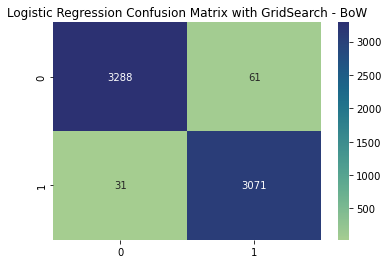

In [58]:
lr_Gs = LogisticRegression(max_iter = 20000, solver = 'lbfgs', class_weight = 'balanced' )
param = {'C':[0.001, 0.01, 0.1, 1, 10, 100]}
clf_lr = GridSearchCV(lr, param_grid= param, cv = 5, n_jobs = -1).fit(X_trainset_features, Y_trainset)

clf_lr.best_params_

clf_lr.best_estimator_

clf_lr_pred = clf_lr.predict(X_testset_features)
lr_detect = accuracy_score(Y_testset, clf_lr_pred)

print("Accuracy on test data: " , lr_detect)

#Evaluating the classficiation 
print(classification_report(Y_testset, clf_lr_pred))

clf_lr_CM = confusion_matrix(Y_testset, clf_lr_pred)
sns.heatmap(clf_lr_CM, annot = True, fmt='d', cmap='crest')
plt.title("Logistic Regression Confusion Matrix with GridSearch - BoW")

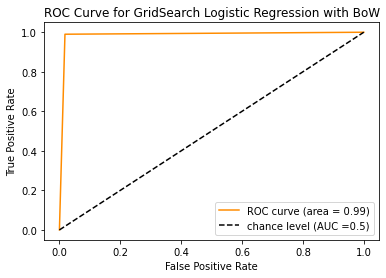

In [59]:
fpr, tpr, thresholds = roc_curve(Y_testset, clf_lr_pred)

#calculating auc
clf_lr_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % clf_lr_auc)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC =0.5)")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for GridSearch Logistic Regression with BoW')
plt.legend()
plt.show()